In [1]:
import pandas as pd

Часы fitbit собирают ежедневную статистику о моей физической активности и сне. Загрузив эту статистику, я задался вопросом коррелируют ли моя физическая активность и сон? 

Загружаю статистику сна, скачанную из личного кабинета портала fitbit.com

In [2]:
sleep = pd.read_csv("sleep.csv", header=1, parse_dates=['Start Time'])
sleep = sleep.drop('End Time', axis=1)
sleep = sleep.rename(columns={'Start Time': 'Date'})

Оставляю записи за февраль и перевожу колонку Date в формат datetime64

In [3]:
sleep = sleep[sleep['Date'].dt.month == 2]
sleep['Date'] = sleep['Date'].dt.date
sleep['Date'] = pd.to_datetime(sleep['Date'])

In [4]:
sleep = sleep.sort_values(by='Date').reset_index().drop('index', axis=1)
sleep.head()

,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
0,2021-02-01,364,79,23,443,39,262,63
1,2021-02-02,487,73,36,560,88,351,48
2,2021-02-03,430,48,38,478,61,334,35
3,2021-02-04,384,61,28,445,61,254,69
4,2021-02-05,400,52,31,452,85,266,49


Загружаю статистику дневной активности за февраль, скачанную из личного кабинета портала fitbit.com

In [5]:
activity = pd.read_csv("activity.csv", header=1, parse_dates=['Date'])

Объединяю сон и активность в единый dataframe

In [6]:
sleep_n_do = pd.merge(sleep,activity, on='Date')
sleep_n_do.head()

,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2021-02-01,364,79,23,443,39,262,63,2737,9421,4.23,34,577,312,31,27,1485
1,2021-02-02,487,73,36,560,88,351,48,2475,8081,3.64,23,660,320,14,3,1181
2,2021-02-03,430,48,38,478,61,334,35,2526,8273,3.75,21,569,278,29,4,1202
3,2021-02-04,384,61,28,445,61,254,69,2753,10770,4.91,33,593,305,51,13,1499
4,2021-02-05,400,52,31,452,85,266,49,3252,11680,5.26,29,488,410,84,13,2119


Смотрю на корреляцию признаков

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

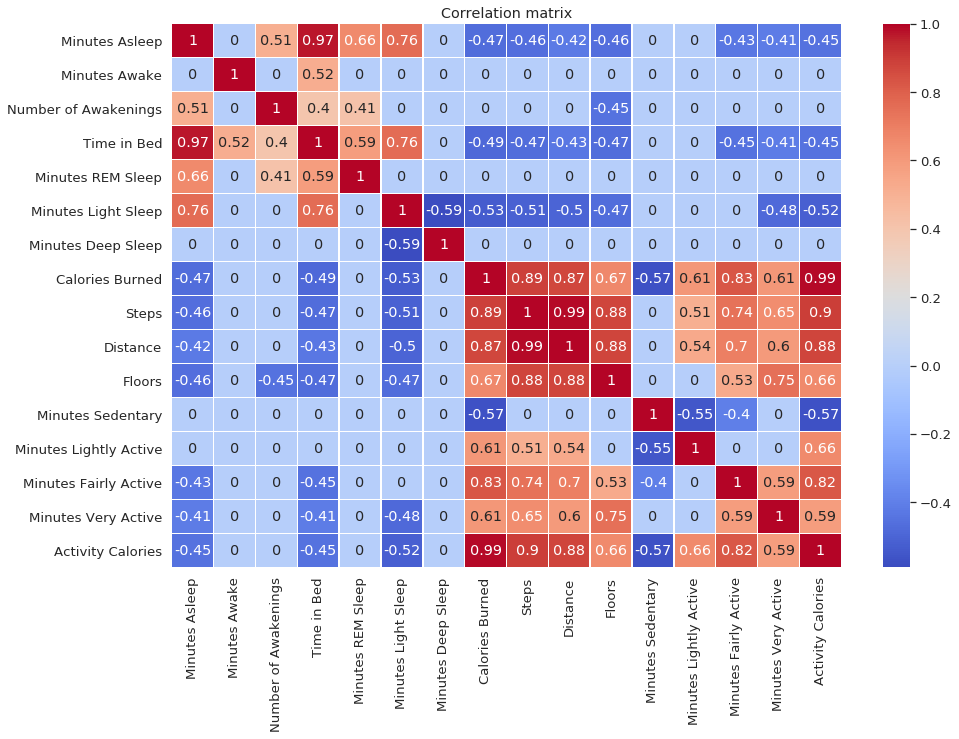

In [8]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.2)

corr_matrix = sleep_n_do.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.4] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix');

Из таблицы выше видно, что Minutes Light Sleep и Calories Burned, возможно, коррелируют. Составим две гипотизы: <br>
H<sub>0</sub>: Используя признак Minutes Light Sleep и формулу линейной регрессии нельзя предсказать дневную активность (признак Calories Burned).<br>
H<sub>1</sub>: Используя признак Minutes Light Sleep и формулу линейной регрессии можно предсказать дневную активность (признак Calories Burned).

Для последующих вычислений используем уровень значимости 0,05

Посмотрим на средние значения, стандартные отклонения и нарисуем простые графики плотности для этих двух переменных, но сначала стандардизуем признаки.

In [9]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

In [10]:
activity['Calories Burned'] = scaler.fit_transform(activity[['Calories Burned']])
activity['Calories Burned'].head()

0    0.841636
1    0.761070
2    0.776753
3    0.846556
4    1.000000
Name: Calories Burned, dtype: float64

In [11]:
activity['Calories Burned'].mean()

0.7868784044983308

In [12]:
activity['Calories Burned'].std()

0.0697955930035077

In [13]:
sleep['Minutes Light Sleep'] = scaler.fit_transform(sleep[['Minutes Light Sleep']])
sleep['Minutes Light Sleep'].head()

0    0.675258
1    0.904639
2    0.860825
3    0.654639
4    0.685567
Name: Minutes Light Sleep, dtype: float64

In [14]:
sleep['Minutes Light Sleep'].mean()

0.7369293078055966

In [15]:
sleep['Minutes Light Sleep'].std()

0.10759299754283987

In [16]:
import seaborn as sns

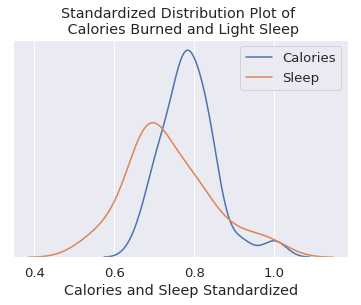

In [17]:
import warnings
warnings.filterwarnings('ignore')
sns.distplot(activity['Calories Burned'], hist=False, label="Calories");
sns.distplot(sleep['Minutes Light Sleep'], hist=False, label="Sleep");
plt.xlabel ("Calories and Sleep Standardized")
plt.yticks([])
plt.title("Standardized Distribution Plot of \n Calories Burned and Light Sleep");

Количество наблюдений:

In [18]:
k = len(sleep)
k

28

Пусть x - это Calories Burned, а у - это Minutes Light Sleep

In [23]:
x = activity['Calories Burned']
y = sleep['Minutes Light Sleep']

Воспользуемся формулой линейной функции y = a + bx и начнем с нахождения коэффициента b:
$$b = \frac{\overline{yx} - \overline{y} \cdot {\overline{x}}}{\overline{x^2} - (\overline{x})^2}$$

In [24]:
b = (np.mean(x * y) - np.mean(x) * np.mean(y)) / (np.mean(x**2) - np.mean(x) ** 2)
b

-0.7468157471384416

Затем, найдем коэффициент a: $$a = \overline{y} - b \cdot {\overline{x}}.$$

In [25]:
a = np.mean(y) - b * np.mean(x)
a

1.3245824913681223

Следовательно, в нашем случае корреляция сна (Minutes Light Sleep) и калорий (Calories Burned) имеет следующую формулу линейной регрессии: y = 1,32 - 0,75x

Теперь, можно посмотреть на коэффициент корреляции:

In [26]:
r = (b * np.std(x)) / np.std(y)
r

-0.4844594827384655

и детерминации:

In [27]:
R2 = round(r**2,4)
R2

0.2347

Только 23,47% вариации сна (Light Sleep) можно объяснить признаком Calories Burned (дневной активностью)

Попробуем предсказать сон составленной формулой регрессии:

In [28]:
y_pred = a + b * x
y_pred.head()

0    0.696036
1    0.756203
2    0.744491
3    0.692361
4    0.577767
Name: x, dtype: float64

Сравним полученные предсказания визуально:

In [33]:
yy_pred = pd.DataFrame({'Калории':x, 'Сон':y, 'Модель': y_pred})
yy_pred.head()

,Калории,Сон,Модель
0,0.841636,0.675258,0.696036
1,0.761070,0.904639,0.756203
2,0.776753,0.860825,0.744491
3,0.846556,0.654639,0.692361
4,1.000000,0.685567,0.577767


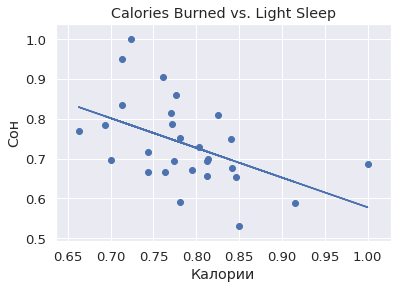

In [30]:
plt.scatter(yy_pred['Калории'],yy_pred['Сон']);
plt.plot(yy_pred['Калории'],yy_pred['Модель']);
plt.xlabel('Калории');
plt.ylabel('Сон');
plt.title('Calories Burned vs. Light Sleep');

Визуально, модель сильно сглаживает высокие значения сна. Проверим эту ошибку статистически.

In [31]:
A = (y - y_pred) / y
A_mean = np.mean(np.abs(A))*100
round(A_mean,2)

10.36

Ошибка аппроксимации в 10% подтверждает визуальную оценку качества полученной модели. Попробуем оценить качество и при помощи F-критерия Фишера:
$$F_{факт} = \frac{r_{xy}^{2} \cdot (n - 2)}{(1 - r_{xy}^{2})}$$

In [32]:
F_fact = round(r**2*(len(x)-2) / (1-r**2),2)
F_fact

7.97

k<sub>1</sub> = 1, т. к. формула регрессии включает только один признак. k<sub>2</sub> = 28 - 2 = 26, т. к. количество наблюдений n = 28. Пользуясь уровнем значимости 0,05, степенями свободы k<sub>1</sub> и k<sub>2</sub>,  и таблицей Фишера, находим, что F<sub>крит</sub> = 4.2252 <br>
Так как F<sub>факт</sub> = 7.97 > F<sub>крит</sub> = 4.2252, то наше уравнение регрессии является статистически значимым.

Для того, чтобы отвергнуть нулевую гипотезу H<sub>0</sub> необходимо подсчитать значения t-статистики:

In [37]:
s_residual = np.sqrt(np.sum((y - y_pred)**2) / (len(x) - 2))
m_a = s_residual * np.sqrt(np.sum(x ** 2)) / (len(x) * np.std(x))
m_b = s_residual / (np.std(x) * np.sqrt(len(x)))

print('s_residual = {}\nm_a = {}\nm_b = {}'.format(s_residual, m_a, m_b))

s_residual = 0.09591682420123131
m_a = 0.20889773094540298
m_b = 0.2644751714224125


In [38]:
t_a = a / m_a
t_a

6.340817994400869

In [39]:
t_b = b / m_b
t_b

-2.8237650556076126

Используя 26 степеней свободы и таблицу t-критерия Стьюдента, находим t<sub>кр</sub> = 2,056 <br>
Так как t_a = 6,34 >  t<sub>кр</sub> = 2,056, то найденное нами значение наклона a = 1,32 является статистически значимым. В тоже время, t_b = -2,82 < t<sub>кр</sub> = 2,056 и, следовательно, формула регрессии целиком не является качественным предсказателем признака Calories Burned по признаку Minutes Light Sleep. Так как t_b меньше значения t<sub>кр</sub>, то мы не можем отказатья от гипотизы H<sub>0</sub> в пользу алтернотивной гипотизы. THE END.